### Perform EDA and analysis
**program:** 08_nb_mod_h100 <br>
**author:** chris chan<br>
**date:** jan 27,2021<br>
**desc:** use clean df for analysis <br>

**datasources:**<br>
- sb_analytic (balanced df thru 2010)
- billboard analytic (hot 100 thru 2019)
- spotify random (random thru 2020)

**articles**<br>
https://towardsdatascience.com/understanding-bayes-theorem-7e31b8434d4b![image.png](attachment:image.png)
https://towardsdatascience.com/understanding-the-naive-bayes-classifier-16b6ee03ff7b![image-2.png](attachment:image-2.png)

**log reg workflow (kf cv)**<br>
1. split 2 times (train,val,test)
2. select features / label
3. standardize if necessary
4. define a kfold split object
5. instantiate your model
6. cross val score: apply 4,5. fit the model
7. cross val predict: apply 4,5. get predicted vals on training set
8. get scores: based on 6, define the score you want (if not accuracy). Also get classification report (f1,precision, etc.)
9. confusion matrix: apply 7. based on training set
10. AUC/ROC: apply to validation set to evaluate model

a. may need to tune hyperparms by using gridsearchcv. find teh best estimator and place into object<br>
b. refit model using best estimators

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
from sqlalchemy import create_engine
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split

**1. Bring in data**

In [4]:
sbdf=pd.read_csv(r'../data/clean/sbdf_clean.csv')
sbdf.head(3)

,SpotifyID,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,loudness,is_hit,year
0,285pBltuF7vW8TeWk8hdRR,0.511,0.566,6,0,0.200,0.3490,0.0,0.340,0.218,83.903,239836,-7.230,1,2018.0
1,7dt6x5M1jzdTEt8oCbisTK,0.680,0.578,10,1,0.040,0.3310,0.0,0.135,0.341,145.038,231267,-5.804,1,2018.0
2,78QR3Wp35dqAhFEc2qAGjE,0.897,0.662,1,0,0.292,0.0852,0.0,0.534,0.389,112.511,145543,-6.903,1,2019.0


**2. Create Label**
- this LR mod is based on 1980 or not (using 1960+)

In [5]:
sbdf['in80']=np.where( (sbdf['year'] >= 1980) & (sbdf['year']<1990),1,0)

**remove rows below 1960**

In [6]:
sbdf = sbdf[sbdf['year'] >= 1960] 

In [7]:
sbdf.in80.value_counts()

0    13944
1       91
Name: in80, dtype: int64

In [8]:
sbdf.columns = map(str.lower, sbdf.columns)

In [9]:
sbdf['decade'] = (sbdf.year//10*10).astype(int)

In [10]:
sbdf.decade.value_counts()

2000    6239
1990    3864
2010    3829
1980      91
1960       8
1970       4
Name: decade, dtype: int64

In [11]:
sbdf = sbdf[sbdf['decade'] >= 1990] 

In [12]:
sbdf['track_seconds'] = sbdf['duration_ms'] / 1000

In [13]:
sbdf.columns

Index(['spotifyid', 'danceability', 'energy', 'key', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'loudness', 'is_hit', 'year', 'in80', 'decade',
       'track_seconds'],
      dtype='object')

In [ ]:
sbdf.info()

**1. SPlit Data** 

In [14]:
# Split first to remove test data
df_train_st, df_test_st = train_test_split(sbdf, test_size=0.2, random_state=42 ) #, stratify=y)

# SPlit again between train and val
df_train, df_test = train_test_split(df_train_st, test_size=0.2, random_state=42 ) #, stratify=y)

#df_train, df_test = train_test_split(bbdf, test_size=0.2, random_state=42)

In [17]:
features = ['acousticness','danceability','energy','loudness','valence','track_seconds']
labels = ['is_hit']        

#X_train = scaler.fit_transform(df_train[features])
X_train = df_train[features]
y_train = df_train[labels]

X_test = df_test[features]
y_test = df_test['is_hit']

### Gaussian Example: 

In [18]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.74069089277703

**cc : gaussion things are dist normally** <br>
prob of A or prob B - its not jsut one number. we're defining the prob by a distribution. and teh distributino is defined by mean and variance<br>
naieve: stores the mean and variance

In [19]:
nb.theta_ # mean of each feature by classa

array([[ 3.39291206e-01,  5.46869737e-01,  6.04790264e-01,
        -9.53051945e+00,  5.22894797e-01,  2.37826734e+02],
       [ 1.63936673e-01,  6.33707749e-01,  6.83965996e-01,
        -6.64590886e+00,  5.29513764e-01,  2.39467431e+02]])

In [20]:
np.sqrt(nb.sigma_) # variance of each feature by class

array([[  0.34725813,   0.18326361,   0.2588906 ,   5.01988968,
          0.2684577 , 105.14615866],
       [  0.20589302,   0.14647408,   0.17679807,   2.69539537,
          0.22804138,  49.20262011]])

In [21]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB

skf = StratifiedKFold(n_splits=5)
params = {}
nb = GaussianNB()
gs = GridSearchCV(nb, cv=skf, param_grid=params, return_train_score=True)

gs.fit(X_train, y_train)

gs.cv_results_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

{'mean_fit_time': array([0.00441465]),
 'std_fit_time': array([0.00072407]),
 'mean_score_time': array([0.00212817]),
 'std_score_time': array([0.00023482]),
 'params': [{}],
 'split0_test_score': array([0.7382287]),
 'split1_test_score': array([0.74088615]),
 'split2_test_score': array([0.7296691]),
 'split3_test_score': array([0.72854739]),
 'split4_test_score': array([0.7296691]),
 'mean_test_score': array([0.73340009]),
 'std_test_score': array([0.00511363]),
 'rank_test_score': array([1], dtype=int32),
 'split0_train_score': array([0.732894]),
 'split1_train_score': array([0.729707]),
 'split2_train_score': array([0.73489415]),
 'split3_train_score': array([0.73419319]),
 'split4_train_score': array([0.73517454]),
 'mean_train_score': array([0.73337258]),
 'std_train_score': array([0.00199505])}

In [22]:
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.74069089277703

In [23]:
gs.score(X_test, y_test)

0.74069089277703

In [24]:
gs.estimator.get_params().keys()

dict_keys(['priors', 'var_smoothing'])

In [31]:
gs.param_grid = {'alpha': [0.1, .01]}
gs.fit(X_train, y_train)
gs.score(X_test, y_test)

ValueError: Invalid parameter alpha for estimator GaussianNB(). Check the list of available parameters with `estimator.get_params().keys()`.

In [26]:
gs.cv_results_

{'mean_fit_time': array([0.00441465]),
 'std_fit_time': array([0.00072407]),
 'mean_score_time': array([0.00212817]),
 'std_score_time': array([0.00023482]),
 'params': [{}],
 'split0_test_score': array([0.7382287]),
 'split1_test_score': array([0.74088615]),
 'split2_test_score': array([0.7296691]),
 'split3_test_score': array([0.72854739]),
 'split4_test_score': array([0.7296691]),
 'mean_test_score': array([0.73340009]),
 'std_test_score': array([0.00511363]),
 'rank_test_score': array([1], dtype=int32),
 'split0_train_score': array([0.732894]),
 'split1_train_score': array([0.729707]),
 'split2_train_score': array([0.73489415]),
 'split3_train_score': array([0.73419319]),
 'split4_train_score': array([0.73517454]),
 'mean_train_score': array([0.73337258]),
 'std_train_score': array([0.00199505])}

In [32]:
def plot_gaussian(lb, ub, mean=0, std=1, n=200, axis=0, mult=300, add=50):
    '''
    Draw a Gaussian curve on one of the axes, given a lower-bound (lb) and upper-bound (ub)
    '''
    x = np.linspace(lb, ub, n)
    pdf = st.norm.pdf(x, loc=mean, scale=std)
    
    if axis == 0:
        plt.plot(x, pdf * mult + add)
    else:
        plt.plot(pdf * mult + add, x)

ValueError: Length of list vectors must match length of `data` when both are used, but `data` has length 2229 and the vector passed to `y` has length 1.

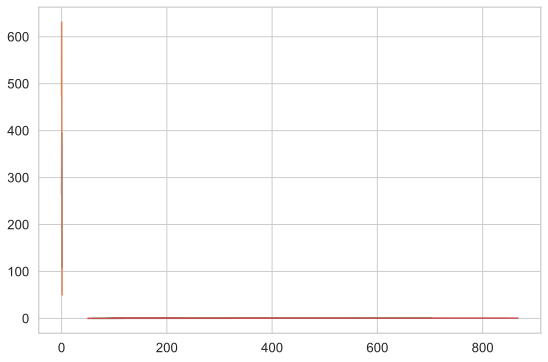

In [34]:
for feature in range(2):
    for gender in range(2):
        plot_gaussian(X_test.iloc[:, feature].min(), 
                      X_test.iloc[:, feature].max(), 
                      nb.theta_[gender][feature],  # See above
                      np.sqrt(nb.sigma_)[gender][feature],  # See above
                      axis=feature)
        
preds = nb.predict(X_test)
wrong_mask = y_test != preds

sns.scatterplot(data=X_test, x=df_test['energy'], y= labels, hue=preds, s=10)
sns.rugplot(data=X_test[wrong_mask], x=df_test['energy'], y=labels, hue=y_test, legend=False);

**cc the likelinhoood is probabily of height x and wegith y (hight 60 or weight 120) given that gender is M or F** <br>
very important graph<br>
wg=120<br>
ht60<br>
given that its' male - so both are low<br>
given that's ifemail<br>
ht60<br>
wg 120<br>
maximize the likelyhood - what's bigger on the distribution<br>
and do that on the other ones<br>
once you have the distributions set<br>


**not very interpretable**
- naive bayes: whats the avg for each class and std for each class
- gradient boosting
- neural networks

Our goal is to predict whether or not the song is a hit or not. For the sake of simplicity, we'll split the data once, between a train set and a test set. *Of course, in practice, you'll want to cross validate with multiple splits of the data.*

## 3. Full Model with more features

We can incorporate more features using the sklearn Logistic Regression implemetation.

In [ ]:
df_train.columns

**a. TRAINING: standardize your features**

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['energy','mode','acousticness','danceability','energy','loudness','key','instrumentalness']

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[features])
y_train = df_train['in80']

In [ ]:
print(X_train)

**b. TRAINING: Fit a model**

In [ ]:
lm_3 = LogisticRegression()  # We'll also regularize our features

In [ ]:
lm_3.fit(X_train, y_train)

**c. TEST: standardize your features**

In [ ]:
X_test = scaler.transform(df_test[features])
y_test = df_test['in80']

preds = lm_3.predict(X_test)

**d. Confusion matrix**

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

confusion_matrix(y_test, preds)

**e. ROC Curve**

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, lm_3.predict_proba(X_test)[:,1])

In [ ]:
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

In [ ]:
plot_roc(df_test['in80'], lm_3.predict_proba(X_test)[:, 1])

**f. Precision and Recall**

In [ ]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

# using the default threshold of 0.5, which is what vanilla predict does
y_predict = lm_3.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

**Whenver my "hit alarm (prediction)" went off, how many times was it actually a hit?? 69%
Whenever there was a true hit, how many times did i predict it to be a hit?? **

- what's more important

In [ ]:
# using the new threshold of 0.06
y_predict = (lm_3.predict_proba(X_test)[:,1] > 0.35)
print("Threshold of 0.06:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

**If i'm prediction a lot more hits (by decreasing my threshold) I'm allowing more false positives - or DECREASING my precision. However I might INCREASE my recall because I've practially predicted all of the hits accordingly**

In [ ]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm_3.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as hit)');
plt.title('Precision and Recall Curves');

In [ ]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

**CC: F1 score** - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. In our case, F1 score is 0.701.

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

**g. F1 scores**

In [ ]:
# Or we can just ask sklearn
y_predict = lm_3.predict(X_test)
f1_score(y_test, y_predict)

In [ ]:
# What about the threshold of 0.06?
y_predict = (lm_3.predict_proba(X_test)[:, 1] > 0.50)
f1_score(y_test, y_predict)

**h. Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predict)
#accuracy_score(y_test, y_predict, normalize=False)

## The ROC curve

We've already seen that we don't have to accept a 50% threshold cutoff. As we've seen, we can plot our models with different thresholds on the same chart and get a ROC curve. This curve plots the *true positive rate* on the y axis, and the *false positive rate* on the x axis. 

In [ ]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, lm_3.predict_proba(X_test)[:,1])

In [ ]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for hits problem');
print("ROC AUC score = ", roc_auc_score(y_test, lm_3.predict_proba(X_test)[:,1]))

## 2. Multi-class Logistic Regression

**This model uses DECADE as the label**

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

In [ ]:
bbdf.columns

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
#digits = datasets.load_digits(n_class=10)

In [ ]:
features = ['acousticness','danceability','energy','loudness','valence','track_seconds']

In [ ]:
bbdf.shape

In [ ]:
# Split first to remove test data
df_train_st, df_test_st = train_test_split(bbdf, test_size=0.2, random_state=42 ) #, stratify=y)

# SPlit again between train and val
df_train, df_test = train_test_split(df_train_st, test_size=0.2, random_state=42 ) #, stratify=y)



We can pick between classifying in two different ways:

#### One vs. Rest (`ovr`)

For each class (in this case, for each number) we will have a separate logistic regression model. Each one of these models assigns a probability for whether an observation is that class, or is "one of the rest". So:

**Model 1:** Calculate $p_1 = P(y=1|x)$ where $y=1$ if the number is *one*, and $y=0$ otherwise

**Model 2:** Calculate $p_2 = P(y=1|x)$ where $y=1$ if the number is *two*, and $y=0$ otherwise

**Model 3:** Calculate $p_3 = P(y=1|x)$ where $y=1$ if the number is *three*, and $y=0$ otherwise

... and so on. Then, **we make the classification by picking the highest $p_i$ among all these models**.

#### Softmax (`multinomial`)

This actually introduces a **new link function**. So, rather than use the traditional sigmoid function here, we use the "softmax" function:

$$
\displaystyle \sigma (\mathbf {z} )_{i}={\frac {e^{z_{i}}}{\sum _{j=1}^{K}e^{z_{j}}}}{\text{ for }}i=1,\dotsc ,K{\text{ and }}\mathbf {z} =(z_{1},\dotsc ,z_{K})\in \mathbb {R} ^{K}
$$

So, again we have $k$ different models, but now we're saying that for each model, use a special link function that actually incorporates some aspect of the other link functions:

**Model 1:** Let $z_1 = \beta_{10} + \beta_{11}x_1 + \dots + \beta_{1k}x_k$ and use the sigmoid link function $\sigma(\mathbf{z})_1$

**Model 2:** Let $z_2 = \beta_{20} + \beta_{21}x_1 + \dots + \beta_{2k}x_k$ and use the sigmoid link function $\sigma(\mathbf{z})_2$

**Model 3:** Let $z_3 = \beta_{30} + \beta_{31}x_1 + \dots + \beta_{3k}x_k$ and use the sigmoid link function $\sigma(\mathbf{z})_3$

... and so on. Notice that each model has its own set of coefficients $\beta_j$ and each link function actually uses the sum of these linear combinations from all the other models. In doing so, **the multinomial method creates a probability distribution among the possible classes**. Then, we just pick the highest probability among this distribution. This is nice for many reasons, and we'll see later that the same concept is actually used in many other aspects of Machine Learning.

In [ ]:
lm_ovr = LogisticRegression(solver='newton-cg', multi_class='ovr')
lm_mn = LogisticRegression(solver='newton-cg', multi_class='multinomial')

In [ ]:
X_train = df_train[features]
y_train = df_train['decade']

In [ ]:
lm_ovr.fit(X_train, y_train)
lm_mn.fit(X_train, y_train)

In [ ]:
preds_ovr = lm_ovr.predict(df_test[features])
preds_mn = lm_mn.predict(df_test[features])

In [ ]:
confusion_matrix(df_test['decade'],preds_ovr)

In [ ]:
confusion_matrix(df_test['decade'], preds_mn)

**Trying a heatmap to show predictions - confusion matrix (on ovr)**

In [ ]:
from sklearn.metrics import confusion_matrix

labels = [1960,1970,1980,1990,2000,2010]
cm = confusion_matrix(df_test['decade'], preds_ovr, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier (one vs all)')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
preds_proba_ovr = lm_ovr.predict_proba(df_test[features])
preds_proba_mn = lm_mn.predict_proba(df_test[features])
#preds_proba_mn = lm_mn.predict_proba(df_test[features])

In [ ]:
def get_multiclass_aucs(labels, scores, name='One-vs-Rest', kind='ovr'):
    ohe = OneHotEncoder()
    labels_ohe = ohe.fit_transform(labels)
    labels_ohe = labels_ohe.toarray()
    
    print(f'Average: {roc_auc_score(labels_ohe, scores, multi_class=kind)}')
    
    auc_scores = roc_auc_score(labels_ohe, scores, multi_class=kind, average=None)
    auc_scores = {i:s for i, s in enumerate(auc_scores)}
    
    return auc_scores


**Keep in mind these are AUC scores**

In [ ]:
print("One-vs-Rest\n")

get_multiclass_aucs(df_test[['decade']], preds_proba_ovr)

In [ ]:
print("Multinomial\n")
get_multiclass_aucs(df_test[['decade']], preds_proba_mn)

**just get accuracy scores**

In [ ]:
# Or we can just ask sklearn
f1_score(y_test, preds_ovr,average='micro')

**h. Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,preds_ovr)
#accuracy_score(y_test, y_predict, normalize=False)

## 4. Cross Validation

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler

# Split first to remove test data
df_train_st, df_test_st = train_test_split(bbdf, test_size=0.2, random_state=42 ) #, stratify=y)

# SPlit again between train and val
df_train, df_test = train_test_split(df_train_st, test_size=0.2, random_state=42 ) #, stratify=y)

**a. scale your vars**

In [ ]:
features = ['acousticness','danceability','energy','loudness','valence','track_seconds']

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[features])
y_train = df_train['decade']

X_test = scaler.fit_transform(df_test[features])
y_test = df_test['decade']


**b. fit model and get accuracy**<br>
**BELOW we have 2 different ways of getting the same CV answers:**

1. you can instantiate an skfold header OR do it directly in steps below
2. you MUST instantiate your logistic regression
3. generally speaking you want to assign your MODEL FIT to an object.<br>
. you should probably ALWAYS do these 2 steps:<br>
    . assign accuracy (during the fit)<br>
    . assign predicted values (during the fit)<br>
. to do a fit you can do the following:<br>
    . model_selection.cross_val_score: this automatically gives you your accuracy scores<br>
    . cross_val_predict: this will give you your predictors SO THAT you can compute your accuracy and other measures based on these PREDICTED values:<br>
        . metrics.accuracy_score: will give you the accuracy score<br>
        . metrics.classification_report: will give you precision/recall/f1/support/accuracy<br>
<br>
. Model 1 below seems to be more comprehensive and flexible

**Model 1:**

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

#skfold = StratifiedKFold(n_splits=5, random_state=42)
skfold = KFold(n_splits=5, random_state=42)
model_skfold = LogisticRegression()
#model_skfold = OneVsRestClassifier() 
#model_skfold = OneVsRestClassifier(LinearSVC(random_state=42)) 
# this fits the model and gets us an accuracy scores (only gets scores)

# accuracy
results_skfold = cross_val_score(model_skfold, X_train, y_train, cv=skfold)

predict_skfold = cross_val_predict(model_skfold, X_train, y_train, cv=skfold)

print("Accuracy: %.2f%%" % (results_skfold.mean()*100.0))
#print(metrics.accuracy_score(y_train,predict_skfold))
print(metrics.classification_report(y_train,predict_skfold))

**AUC: Trying on the TEST Data (to see if it matches with the results above where accuracy was near 80%**

In [ ]:
def get_multiclass_aucs(labels, scores, name='One-vs-Rest', kind='ovr'):
    ohe = OneHotEncoder()
    labels_ohe = ohe.fit_transform(labels)
    labels_ohe = labels_ohe.toarray()
    
    print(f'Average: {roc_auc_score(labels_ohe, scores, multi_class=kind)}')
    
    auc_scores = roc_auc_score(labels_ohe, scores, multi_class=kind, average=None)
    auc_scores = {i:s for i, s in enumerate(auc_scores)}
    
    return auc_scores

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

print("One-vs-Rest\n")
predict_proba_skfold = cross_val_predict(model_skfold, X_test, y_test, cv=skfold,method='predict_proba')
get_multiclass_aucs(df_test[['decade']], predict_proba_skfold)

**back to TRAINING DATA : based on PREDICTED you have your confusion matrix**

In [ ]:
confusion_matrix(df_train['decade'], predict_skfold)

In [ ]:
from sklearn.metrics import confusion_matrix

labels = [1960,1970,1980,1990,2000,2010]
cm = confusion_matrix(df_train['decade'], predict_skfold, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**TESTING**
- here we test one vs rest classifier using sklearn
- we fit the model on train first
- we use the coeffs on test and come up with predictors
- somehow, only 3 years are being predicted from our output

In [ ]:
import math
df_test['decade']= (df_test['decade'].astype(int))
df_train['decade'] = (df_train['decade'].astype(int))

In [ ]:
X_train = df_train[features]
y_train = df_train['decade']

In [ ]:
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

test_fit = OneVsRestClassifier(LinearSVC(random_state=0)).fit(X_train, y_train)
test_pred = test_fit.predict(df_test[features])

In [ ]:
print(test_pred)

In [ ]:
confusion_matrix(df_test['decade'], 
                 test_pred)

In [ ]:
df_test['decade'].value_counts()

In [ ]:
y_train.value_counts()

In [ ]:
(unique, counts) = np.unique(test_pred, return_counts=True)
freqs = np.asarray((unique, counts)).T

print(freqs)

In [ ]:
import math
df_test['decade']= (df_test['decade'].astype(int))


In [ ]:
from sklearn.metrics import confusion_matrix

labels = [1960,1970,1980,1990,2000,2010]
cm = confusion_matrix(df_test['decade'], test_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()